# Summarizing Large Texts

## 1. Introductions

- LLMs are a great tool for generating summaries from large volume of texts.
- LLMs can use summarization to:
    1. **summarize large content sets**: Summarise information from multiple sources such as PDFs, Notion pages, or customer queries into concise, meaningful representations
    2. **Enhance retrieval-augmented generation (RAG)**: Use summarisation to distil the content of retrieved documents, ensuring the LLM receives only the most relevant context.

In this walkthrough we'll go over how to summarize content from multiple documents using LLMs.

### 1.1 Approaches

There are three building a summarizer: 

1. **Stuffing the prompt** If the document fits in to the context window, we can just include the document in the prompt. This is the simplest approach. This is implemented using `create_stuff_documents_chain`

2. **Map Reduce**: If the document(s) do not fit in to the context window, we **map each document into a summary** and then **reduce the summaries of each document into one final summary**. The mapping step is typically done in parallel. This is implemented usinf the [`MapReduceDocumentsChain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html)

3. **Iterative Refinement**: Iterative Refinement builds on Map-Reduce. Map-Reduce is effective when the documents do not have a sequential nature. In other cases, such as summarizing a novel or body of text with an inherent sequence, [iterative refinement](https://python.langchain.com/docs/how_to/summarize_refine/) may be more effective.

![./docs/summarization.png](./docs/summarization.png)


## Setup

In [5]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain langchain_classic langchain-community=0.3.7 langgraph "langchain[openai]"

import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

assert os.environ["LANGSMITH_TRACING"] is not None
assert os.environ["LANGSMITH_API_KEY"] is not None
assert os.environ["LANGSMITH_PROJECT"] is not None
assert os.environ["OPENAI_API_KEY"] is not None

In [6]:

from langchain.chat_models import init_chat_model
from langchain_community.document_loaders import WebBaseLoader

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# we load in our documents. We will use WebBaseLoader to load a blog post:
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

import langchain_core
print(langchain_core.__version__)

1.0.1


## 2. Stuffing the prompt

As mentioned earlier, We can use [`create_stuff_documents_chain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html), especially if using larger context window models such as:

- 128k token OpenAI gpt-4o
- 200k token Anthropic claude-3-5-sonnet-latest

The chain will take a list of documents, insert them all into a prompt, and pass that prompt to an LLM:

In [7]:
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# 1. Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# 2. Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)


# 3. Invoke chain
result = chain.invoke({"context": docs})
print(result)

The article "LLM Powered Autonomous Agents" by Lilian Weng delves into the development of autonomous agents utilizing Large Language Models (LLMs) as their core processors, showcasing their potential beyond generating text to solving complex problems. It breaks down the architecture of LLM-powered agents into three components: 

1. **Planning**: This involves task decomposition, where complex tasks are broken down into subgoals, and self-reflection, allowing agents to learn and refine their actions based on past experiences. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance problem-solving capabilities.

2. **Memory**: This section discusses the categorization of memory into sensory, short-term, and long-term types, with techniques for maximizing information retrieval through Maximum Inner Product Search (MIPS) and external vector stores.

3. **Tool Use**: LLMs can access external tools to extend their capabilities, exemplified by architectures like MRKL (Modular Reas

In [8]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LL|M| Powered| Autonomous| Agents|"| by| Lil|ian| W|eng| discusses| the| concept| and| architecture| behind| autonomous| agents| powered| by| large| language| models| (|LL|Ms|).| It| outlines| three| main| components| crucial| to| these| systems|:| 

|1|.| **|Planning|**|:| Agents| employ| task| decomposition| strategies|,| such| as| Chain| of| Thought| prompting| to| break| down| complex| tasks| and| self|-ref|lect| on| their| actions| to| iter|atively| improve| outcomes|.

|2|.| **|Memory|**|:| The| system| utilizes| various| types| of| memory|,| including| short|-term| (|in|-context| learning|)| and| long|-term| memory| (|via| external| databases| for| retrieval|),| enhancing| the| agent|'s| ability| to| retain| and| recall| information| over| time|.| Techniques| like| Maximum| Inner| Product| Search| (|M|IPS|)| are| employed| for| efficient| information| retrieval|.

|3|.| **|Tool| Use|**|:| The| ability| to| interact| with| external| tools| significantly| expands|

## 3. Map Reduce

- For this approach, we'll first map each document to an individual summary using an LLM. Then we'll reduce or consolidate those summaries into a single global summary.

- Note that the map step is typically parallelized over the input documents.

![](./docs/map-reduce-chain.jpg)

For long texts, we need a mechanism that ensures that the context to be summarized in the reduce step does not exceed a model's context window size. 

This is achieved through **collapsing summaries**.

1. Inputs are **partitioned** based on a token limit
2. **Summaries are generated of the partitions**. This step is repeated until the total length of the summaries is within a desired limit, allowing for the summarization of arbitrary-length text.


Created a chunk of size 1003, which is longer than the specified 1000
/var/folders/x1/zrl57ryx10l614s07glvwcnh0000gp/T/ipykernel_24288/3694897146.py:38: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


Generated 13 documents.


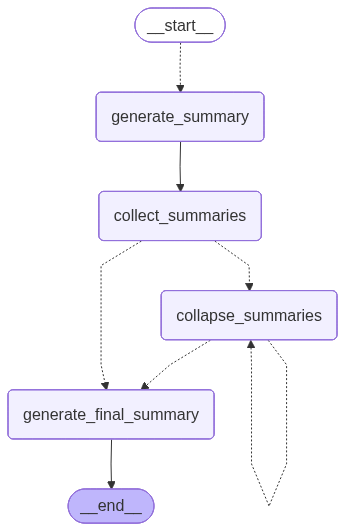

In [10]:
from langchain_core.prompts import ChatPromptTemplate

## 1. MAP REDUCE PROMPTS

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

## 2. Split Documents into chunks

from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

## 

import operator
from typing import Annotated, List, Literal, TypedDict

from langchain_classic.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    # Split Documents into subsets that each meet a cumulative length constraint.
    # i.e. ensure each Document is less than 1000 tokens
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        # Execute a collapse function (_reduce) on a set of documents and merge their metadata
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
# should_collapse returns the name of the function that should be called next, based on the state after Collect_summaries.
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [12]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']
{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the documents emphasizes the following key areas:\n\n1. **Advancements in Autonomous Agents and LLM Integration**:\n   - **Core Components**: Autonomous agents leverage task decomposition strategies (like Chain of Thought) and memory systems (sensory, short-term, and long-term) for enhanced reasoning and effective task management.\n   - **Tool Utilization**: The integration of external APIs is crucial for improved problem-solving capabilities and broader access to information.\n\n2. **Learning and Adaptivity**:\n   - Frameworks suc

In [13]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the documents emphasizes the following key areas:\n\n1. **Advancements in Autonomous Agents and LLM Integration**:\n   - **Core Components**: Autonomous agents leverage task decomposition strategies (like Chain of Thought) and memory systems (sensory, short-term, and long-term) for enhanced reasoning and effective task management.\n   - **Tool Utilization**: The integration of external APIs is crucial for improved problem-solving capabilities and broader access to information.\n\n2. **Learning and Adaptivity**:\n   - Frameworks such as ReAct and Reflexion enable agents to self-reflect, learn from past actions, and enhance their decision-making processes through mechanisms like Chain of Hindsight and Algorithm Distillation.\n\n3. **Generative Agents and Simulated Interactions**:\n   - Generative Agents mimic human behavior and demonstrate emergent social interactions, utilizing memory and refl